<a href="https://colab.research.google.com/github/skyprince999/100Days-of-ML-Code-AY2021/blob/main/Day_2_VERY_SIMPLE_tabular_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing packages & dependencies

To run this notebook. You have to upload the data files from the following Kaggle competition:

https://www.kaggle.com/c/tabular-playground-series-mar-2021

This notebook follows the steps provided by Jeremey Howard in Chap 7 of his book - "Deep Learning"

In [1]:
!pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz

     |████████████████████████████████| 727kB 4.2MB/s 
     |████████████████████████████████| 61kB 4.9MB/s 
     |████████████████████████████████| 51kB 4.4MB/s 
     |████████████████████████████████| 51kB 4.9MB/s 
     |████████████████████████████████| 1.2MB 9.1MB/s 
     |████████████████████████████████| 194kB 17.4MB/s 
     |████████████████████████████████| 51kB 4.2MB/s 
     |████████████████████████████████| 61kB 5.2MB/s 
     |████████████████████████████████| 12.8MB 268kB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
ERROR: torchtext 0.9.0 has requirement torch==1.8.0, but you'll have torch 1.7.1 which is incompatible.


In [2]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [3]:
#hide
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix

from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

import matplotlib.pyplot as plt
import numpy as np
import itertools

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [6]:
!pwd

/content


In [7]:
path = Path('/content')   # /kaggle/input/tabular-playground-series-mar-2021/
df = pd.read_csv(path/'train.csv', low_memory=False)
print(df.shape)
df.columns

(300000, 32)


Index(['id', 'cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7',
       'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15',
       'cat16', 'cat17', 'cat18', 'cont0', 'cont1', 'cont2', 'cont3', 'cont4',
       'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'target'],
      dtype='object')

## Read the data 

There are a lot of columns (!!!) Both categorical as well as continous. 
Lets take one of the categorical variables and examine it

But first lets print out all the unique values of each categorical variable

In [8]:
for col in df.columns:
    if col.startswith('cat'):
        print(f"{col} :: ",df[col].unique())
        print()

cat0 ::  ['A' 'B']

cat1 ::  ['I' 'K' 'A' 'F' 'L' 'N' 'J' 'M' 'O' 'B' 'H' 'G' 'C' 'D' 'E']

cat2 ::  ['A' 'G' 'C' 'O' 'D' 'F' 'Q' 'J' 'L' 'I' 'M' 'H' 'U' 'N' 'R' 'E' 'K' 'S' 'B']

cat3 ::  ['B' 'A' 'C' 'D' 'G' 'N' 'H' 'F' 'E' 'K' 'I' 'J' 'L']

cat4 ::  ['B' 'E' 'H' 'I' 'D' 'F' 'G' 'M' 'K' 'J' 'T' 'C' 'L' 'P' 'S' 'O' 'N' 'Q' 'A' 'R']

cat5 ::  ['BI' 'AB' 'BU' 'M' 'T' 'K' 'L' 'CG' 'BG' 'CI' 'N' 'G' 'X' 'Q' 'O' 'BO' 'BB' 'BX' 'AF' 'BA' 'BQ' 'CA' 'D' 'AQ' 'AS' 'AW' 'BE' 'CK' 'AL' 'BK' 'AT' 'CL' 'C' 'CF' 'I' 'AH' 'CD' 'AY' 'BY' 'F' 'AI' 'R'
 'BC' 'BH' 'AA' 'V' 'CE' 'BD' 'AE' 'U' 'AU' 'AP' 'CJ' 'AN' 'AX' 'AR' 'BL' 'J' 'ZZ' 'BR' 'BV' 'H' 'A' 'CC' 'P' 'CH' 'BJ' 'CB' 'BS' 'BN' 'AO' 'AJ' 'BT' 'S' 'E' 'Y' 'AK' 'AM' 'B' 'BM' 'AV' 'AG' 'BF'
 'BP']

cat6 ::  ['A' 'K' 'C' 'I' 'G' 'E' 'M' 'F' 'O' 'D' 'Q' 'S' 'B' 'Y' 'U' 'W']

cat7 ::  ['S' 'W' 'E' 'Y' 'G' 'AV' 'AF' 'AK' 'AH' 'AN' 'J' 'H' 'U' 'AG' 'AS' 'AA' 'B' 'F' 'AI' 'K' 'AD' 'D' 'N' 'I' 'AW' 'AY' 'AX' 'L' 'AL' 'C' 'R' 'P' 'AU' 'O' 'AR' 'AO' 'AE' 'A

We will do some pre-processing, by handling strings & missing data

Lets first check how many NAs are there in each column

In [9]:
df.isnull().sum().sum()

0

In [10]:
#Since no Nulls are there we don't need the proc while pre-processing the data 

procs = [Categorify] #, FillMissing]

# defining the target variable
dep_var = 'target'

# defining the splits - 80/20 :: tain/valid

splits = RandomSplitter(valid_pct=0.2)(range_of(df))

In [11]:
# Identifying the continous (cont) and categorical (cat) variables

cont,cat = cont_cat_split(df, 1, dep_var=dep_var)

In [12]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [13]:
len(to.train),len(to.valid)

(240000, 60000)

In [14]:
#hide_output
to.show(3)

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,id,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
70060,A,F,C,A,E,BI,A,E,AK,A,DJ,A,A,A,B,C,D,D,B,117060,0.473064,0.330491,0.324767,0.591703,0.786936,0.261320,0.401539,0.365583,0.370476,0.294662,0.382934,0
43938,A,L,A,B,F,BI,A,G,Y,A,AP,A,A,A,B,D,B,B,B,73150,0.662536,0.465372,0.801938,0.842646,0.234898,0.055178,0.232538,0.886359,0.755791,0.706764,0.981385,0
162493,B,I,A,A,G,BI,A,J,Q,A,HK,A,A,A,A,B,D,D,B,270949,0.502375,0.706039,0.696211,0.333573,0.380315,0.781232,0.613433,0.571637,0.382232,0.534854,0.519604,1


The conversion of categorical columns to numbers is done by simply replacing each unique level with a number. The numbers associated with the levels are chosen consecutively as they are seen in a column, so there's no particular meaning to the numbers in categorical columns after conversion. The exception is if you first convert a column to a Pandas ordered category (as we did for ProductSize earlier), in which case the ordering you chose is used. We can see the mapping by looking at the classes attribute:

In [15]:
#hide_output - 
to.items.head(3)

,id,cat0,cat1,cat2,...,cont8,cont9,cont10,target
70060,117060,1,6,3,...,0.370476,0.294662,0.382934,0
43938,73150,1,12,1,...,0.755791,0.706764,0.981385,0
162493,270949,2,9,1,...,0.382232,0.534854,0.519604,1


In [16]:
to.classes['cat10']

['#na#', 'AA', 'AB', 'AC', 'AD', 'AE', 'AF', 'AG', 'AH', 'AJ', 'AK', 'AL', 'AM', 'AN', 'AP', 'AR', 'AS', 'AT', 'AU', 'AV', 'AW', 'AY', 'BA', 'BB', 'BC', 'BD', 'BF', 'BG', 'BI', 'BL', 'BM', 'BO', 'BP', 'BQ', 'BS', 'BT', 'BV', 'BX', 'BY', 'C', 'CB', 'CC', 'CD', 'CF', 'CG', 'CH', 'CI', 'CJ', 'CK', 'CL', 'CM', 'CN', 'CO', 'CP', 'CQ', 'CR', 'CS', 'CT', 'CU', 'CW', 'CX', 'CY', 'D', 'DA', 'DC', 'DD', 'DE', 'DF', 'DH', 'DI', 'DJ', 'DK', 'DL', 'DM', 'DN', 'DO', 'DP', 'DQ', 'DR', 'DS', 'DT', 'DU', 'DV', 'DW', 'DX', 'DY', 'E', 'EA', 'EB', 'EC', 'ED', 'EE', 'EF', 'EG', 'EH', 'EI', 'EK', 'EL', 'EN', 'EO', 'EP', 'EQ', 'ES', 'EU', 'EV', 'EW', 'EY', 'F', 'FA', 'FB', 'FC', 'FD', 'FE', 'FF', 'FG', 'FH', 'FI', 'FJ', 'FK', 'FL', 'FM', 'FN', 'FO', 'FP', 'FQ', 'FR', 'FS', 'FT', 'FV', 'FW', 'FX', 'G', 'GA', 'GB', 'GC', 'GD', 'GE', 'GF', 'GG', 'GH', 'GI', 'GJ', 'GK', 'GL', 'GM', 'GN', 'GQ', 'GR', 'GS', 'GT', 'GU', 'GV', 'GW', 'GX', 'GY', 'HA', 'HB', 'HC', 'HE', 'HF', 'HG', 'HH', 'HI', 'HJ', 'HK', 'HL', 'HM', 

## Training a DT & explaining model

With max leaf nodes as 4 (*to reduce training time*)

In [18]:
%%time
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

m = DecisionTreeClassifier(max_leaf_nodes=4)
m.fit(xs, y);

CPU times: user 1.91 s, sys: 7.26 ms, total: 1.92 s
Wall time: 1.93 s


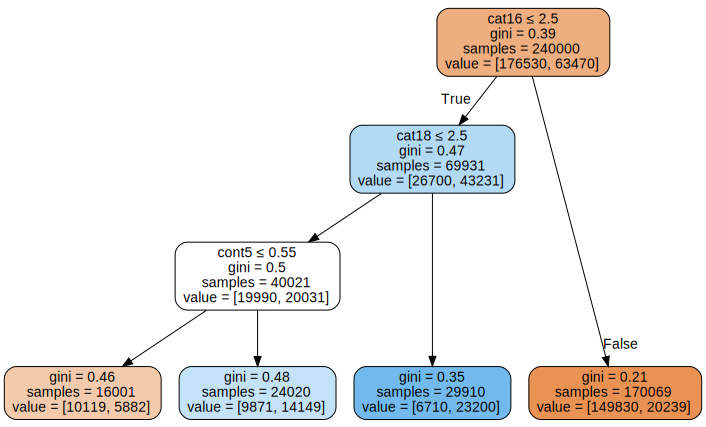

In [19]:
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

1. The top node represents the *initial model* It's the simples model! 
2. We do a greedy division of the data based on the cat16. If the value is less than or equal to 2.5 we move to the left if not then to right

... and so on to create the 4 leaf nodes


In [20]:
to.classes['cat16']

['#na#', 'A', 'B', 'C', 'D']

In [21]:
to['cat16'].unique()

array([4, 2, 1, 3], dtype=int8)

This shows a chart of the distribution of the data for each split point. 

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


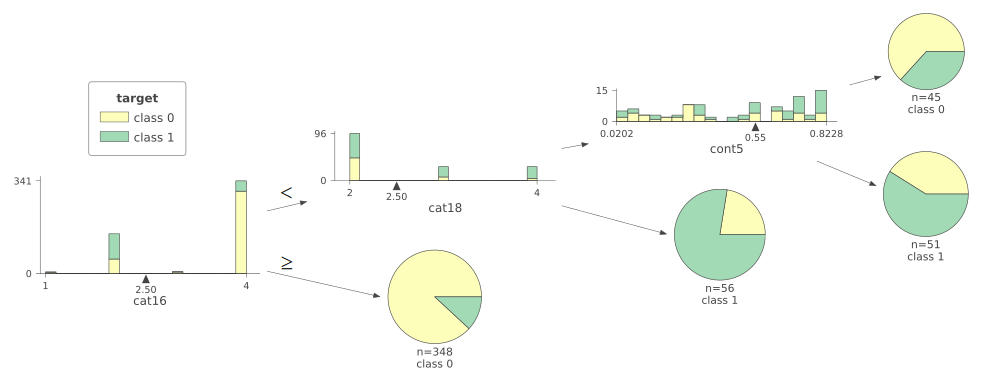

In [22]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

Lets try to see how the model performs when the `max_leaf_node` limit is removed

In [23]:
m = DecisionTreeClassifier()
m.fit(xs, y);

## Defining helper functions 

`get_auc_scores` 

`plot_roc_curve`

In [24]:

def get_auc_scores(clf, X_train, X_test, y_train, y_test):
    """
    Prints the AUC scores for training and testing data
    and returns testing score
    """
    y_train_score = clf.predict_proba(X_train)[:, 1]
    y_test_score = clf.predict_proba(X_test)[:, 1]
    auc_train = roc_auc_score(y_train, y_train_score)
    auc_test = roc_auc_score(y_test, y_test_score)
    print(f" Training AUC: {auc_train}, Testing AUC: {auc_test}")

    return y_test_score

In [25]:
y_test_score = get_auc_scores(m , xs, valid_xs, y, valid_y)

 Training AUC: 1.0, Testing AUC: 0.708296511495617


In [26]:
def plot_roc_curve(y_test, y_test_score):
    """Plot ROC curve for testing data"""

    fpr, tpr, _ = roc_curve(y_test, y_test_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], "k-")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.legend(loc="lower right")
    plt.show()

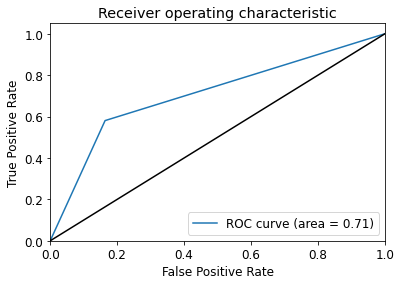

In [27]:
plot_roc_curve(valid_y, y_test_score)

There appears to be major overfitting during training!

Lets check how many leaves are model is using vs the number of training samples

In [28]:
m.get_n_leaves(), len(xs)

(27344, 240000)

Though we have not got as many leaf nodes as the training data... there are still too many leaf nodes vs data points! 

That seems a little over-enthusiastic. Indeed, sklearn's default settings allow it to continue splitting nodes until there is only one item in each leaf node. Let's change the stopping rule to tell sklearn to ensure every leaf node contains at least 25 records:

In [29]:
m = DecisionTreeClassifier(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
y_test_score = get_auc_scores(m, xs, valid_xs, y, valid_y)

 Training AUC: 0.9282614374167998, Testing AUC: 0.8378018557238534


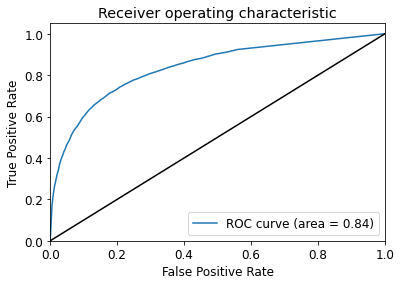

In [30]:
plot_roc_curve(valid_y, y_test_score)

This seems better!!! At least we are not overfitting the training set. 

And the AUC curve for the validation dataset is also better. This shows us that we are on the right track! 

Let's check how many leaf-nodes were used for training

In [31]:
m.get_n_leaves()

5482

Lets now define a RandomForest Classifier 

In [32]:
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [33]:
%%time
m = rf(xs, y);

CPU times: user 2min 53s, sys: 177 ms, total: 2min 53s
Wall time: 1min 29s


In [34]:
y_test_score_1 = get_auc_scores(m, xs, valid_xs, y, valid_y)

 Training AUC: 0.9832876086147577, Testing AUC: 0.8793360836922062


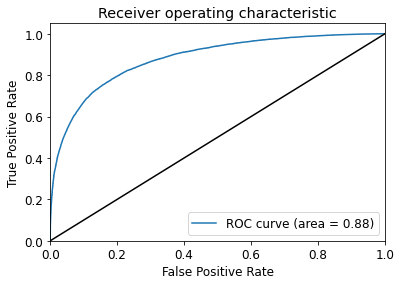

In [35]:
plot_roc_curve(valid_y, y_test_score_1)

.....and yes, there is some improvement! 

In [36]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [37]:
auc = roc_auc_score(valid_y, preds.mean(0))
auc

0.8761509531369569

As can be seen as we add more estimators, the AUC score keeps on increasing, but there is a tapering off after the 30th tree

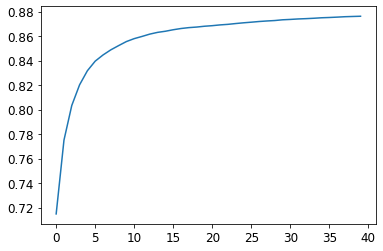

In [38]:
plt.plot([roc_auc_score(valid_y, preds[:i+1].mean(0)) for i in range(40)]);

We saw how the model averages the individual tree's predictions to get an overall prediction—that is, an estimate of the value. But how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions across the trees, instead of just the mean. This tells us the relative confidence of predictions. In general, we would want to be more cautious of using the results for rows where trees give very different results (higher standard deviations), compared to cases where they are more consistent (lower standard deviations).

In the earlier section on creating a random forest, we saw how to get predictions over the validation set, using a Python list comprehension to do this for each tree in the forest:

In [39]:
preds.shape

(40, 60000)

Now we have a prediction for every tree and every auction (40 trees and 60k data points) in the validation set.

Using this we can get the standard deviation of the predictions over all the trees, for each data point:

In [40]:
preds_std = preds.std(0)
preds_std[:5]

array([0.15612495, 0.        , 0.        , 0.        , 0.26339134])

## Feature Importance

It's not normally enough just to know that a model can make accurate predictions—we also want to know how it's making predictions. feature importance gives us insight into this. We can get these directly from sklearn's random forest by looking in the `feature_importances_` attribute. Here's a simple function we can use to pop them into a DataFrame and sort them:

In [41]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [42]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
16,cat16,0.257942
15,cat15,0.083476
18,cat18,0.068109
25,cont5,0.058900
26,cont6,0.042264
21,cont1,0.037194
24,cont4,0.036112
22,cont2,0.035514
23,cont3,0.033570
28,cont8,0.032505


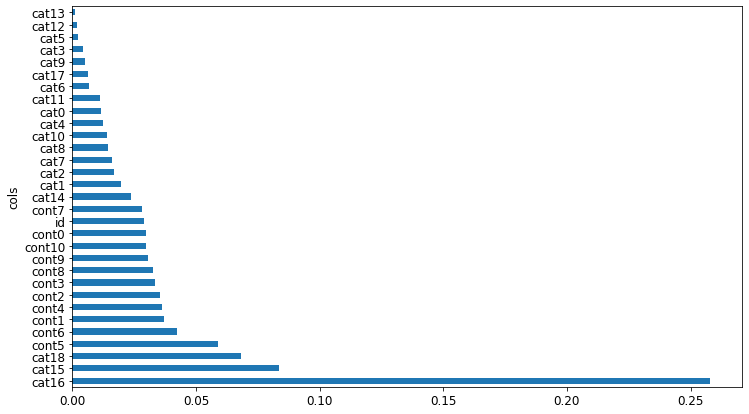

In [43]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:32]);

The way these importances are calculated is quite simple yet elegant. The feature importance algorithm loops through each tree, and then recursively explores each branch. At each branch, it looks to see what feature was used for that split, and how much the model improves as a result of that split. The improvement (weighted by the number of rows in that group) is added to the importance score for that feature. This is summed across all branches of all trees, and finally the scores are normalized such that they add to 1.

We select the features which give normalized importance scores of > 0.005

In [44]:
# Keeping only the important variables
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

27

In [45]:
%%time
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

m = rf(xs_imp, y)

y_test_score = get_auc_scores(m, xs_imp, valid_xs_imp, y, valid_y)

 Training AUC: 0.983152832811294, Testing AUC: 0.8786427331517267
CPU times: user 2min 52s, sys: 201 ms, total: 2min 52s
Wall time: 1min 28s


Though the AUC score has not improved, we have reduced the number of columns/


In [46]:
len(xs.columns), len(xs_imp.columns)

(31, 27)

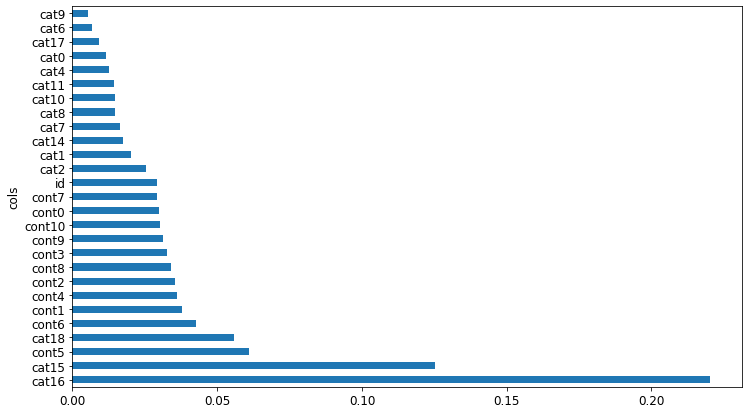

In [47]:
plot_fi(rf_feat_importance(m, xs_imp));

## Removing redundant features

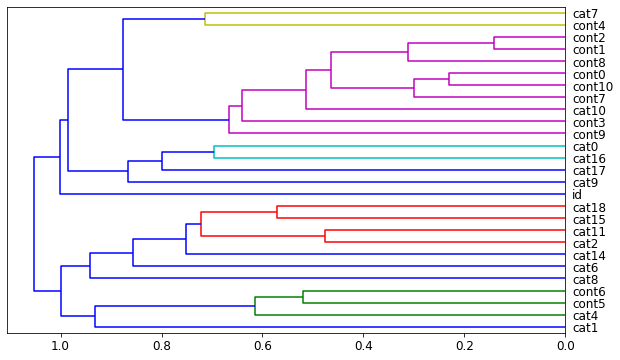

In [48]:
cluster_columns(xs_imp)

* In this chart, the pairs of columns that are most similar are the ones that were merged together early, far from the "root" of the tree at the left.
* These might be so closely correlated they are practically synonyms for each other
* Let's try removing some of these closely related features to see if the model can be simplified without impacting the accuracy.
* First, we create a function that quickly trains a random forest and returns the `oob_score_` score
* we're just going to use it to compare different models, based on removing some of the possibly redundant columns


In [49]:
def get_oob(df):
    m = RandomForestClassifier(n_estimators=40, min_samples_leaf=15,
        max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [50]:
get_oob(xs_imp) # This is our reference point 

0.8435291666666667

In [51]:
%%time
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'cont2', 'cont1', 'cont0', 'cont10', 'cat11', 'cat2', 
    'cont6', 'cont5', 'cat18', 'cat15', 'cat0', 'cat16')}

CPU times: user 8min 39s, sys: 1.5 s, total: 8min 40s
Wall time: 4min 40s


{'cat0': 0.8430083333333334,
 'cat11': 0.8429041666666667,
 'cat15': 0.842025,
 'cat16': 0.8399958333333334,
 'cat18': 0.8432958333333334,
 'cat2': 0.8430833333333333,
 'cont0': 0.8429875,
 'cont1': 0.8434125,
 'cont10': 0.8433791666666667,
 'cont2': 0.8430041666666667,
 'cont5': 0.8418833333333333,
 'cont6': 0.8431708333333333}

* It seems that there is not much difference when you drop the variables (except for `cat16` ...which we have seen to have high feature importance)
* Now let's try dropping multiple variables. We'll drop one from each of the tightly aligned pairs we noticed earlier. We will also use the result from the above 

And see what it does to our OOB scores:

In [52]:
%%time
to_drop = ['cont1', 'cont10', 'cat2', 'cont6', 'cat0'] # The selection of these variables takes some trial & error
                                                       # I checked the feature importance plot & the above oob_scores to
                                                       # select the best set 

get_oob(xs_imp.drop(to_drop, axis=1))

CPU times: user 36.6 s, sys: 47.9 ms, total: 36.6 s
Wall time: 19.8 s


Wow!! There is a slight drop in oob_scores but seems okay...and we can go ahead with dropping these columns

In [53]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

m = rf(xs_final, y)
y_test_score = get_auc_scores(m, xs_final, valid_xs_final, y, valid_y)

 Training AUC: 0.9805052767364445, Testing AUC: 0.8750093888377096


In [54]:
fi = rf_feat_importance(m, xs_final)
print(fi[:10])

    cols       imp
0  cat16  0.239888
1  cat15  0.105977
3  cont5  0.072137
2  cat18  0.066062
5  cont2  0.050495
4  cont4  0.046512
7  cont8  0.044874
6  cont3  0.044267
9  cont0  0.039967
8  cont9  0.039442


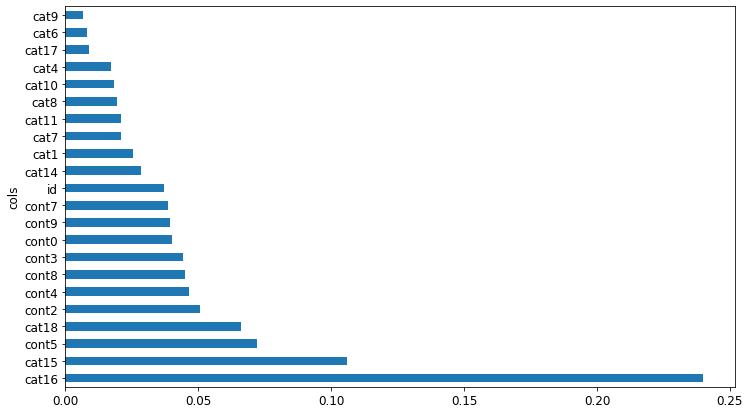

In [55]:
plot_fi(fi)

## Partial Dependence Plots

The top 5 variables as per the feature importance are. 
We will see if there are any relationships between them and the target variable:

* cat16
* cat15
* cont5
* cat18
* cont2

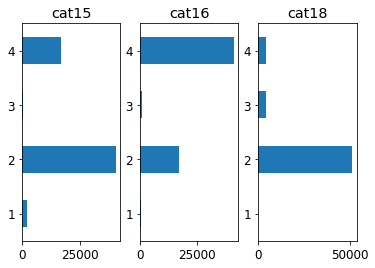

In [56]:
figure, axis = plt.subplots(1, 3) 
cat_columns_interest = ['cat15', 'cat16', 'cat18']
for idx in range(3) :
    p = valid_xs_final[cat_columns_interest[idx]].value_counts(sort=False).plot.barh(ax = axis[idx])
    c = to.classes[cat_columns_interest[idx]]
    #plt.yticks(range(len(c)), c)
    axis[idx].set_title(f"{cat_columns_interest[idx]}");

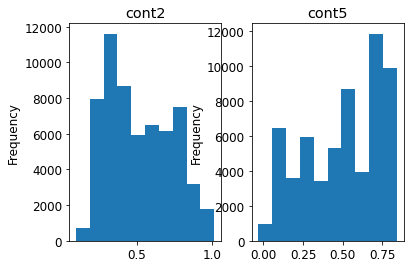

In [57]:
figure, axis = plt.subplots(1, 2) 
cont_columns_interest = ['cont2', 'cont5']
for idx in range(2) :
    p = valid_xs_final[cont_columns_interest[idx]].plot.hist(ax = axis[idx])
    #plt.yticks(range(len(c)), c)
    axis[idx].set_title(f"{cont_columns_interest[idx]}");

Partial dependence plots try to answer the question: if a row varied on nothing other than the feature in question, how would it impact the dependent variable?

For example how does the change in `cat16` value impactthe `target` variable

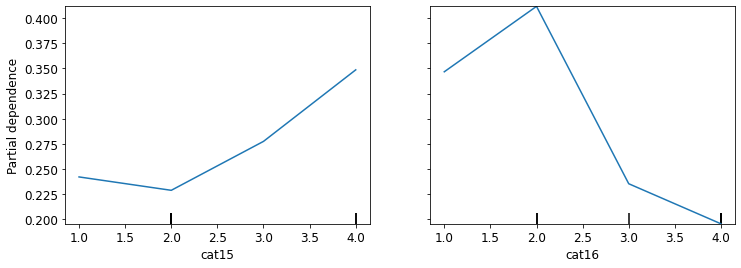

In [58]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, valid_xs_final, ['cat15','cat16'],
                        grid_resolution=20, ax=ax);

The above plot shows that for larger values for `cat15` >>> its likely to move the probability closer to 1.0 

However for `cat16` notice the peak & valley at  2.0 & 4.0 respectiely

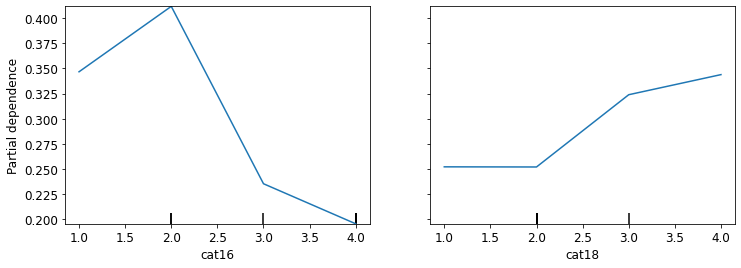

In [59]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, valid_xs_final, ['cat16','cat18'],
                        grid_resolution=20, ax=ax);

## Tree Interpretation

In [61]:
#hide
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [62]:
row = valid_xs_final.iloc[:5]

prediction,bias,contributions = treeinterpreter.predict(m, row.values)

In [63]:
prediction[0], bias[0], contributions[0].sum()

(array([0.9875, 0.0125]),
 array([0.73553537, 0.26446462]),
 -3.821812658011403e-17)

In [64]:
# Needed this code block to understand splicing of 3D arrays
contributions[0, :,  0].shape

(22,)

In [65]:
valid_xs_final.columns

Index(['cat16', 'cat15', 'cat18', 'cont5', 'cont4', 'cont2', 'cont3', 'cont8',
       'cont9', 'cont0', 'id', 'cont7', 'cat14', 'cat1', 'cat7', 'cat8',
       'cat10', 'cat4', 'cat11', 'cat6', 'cat17', 'cat9'],
      dtype='object')

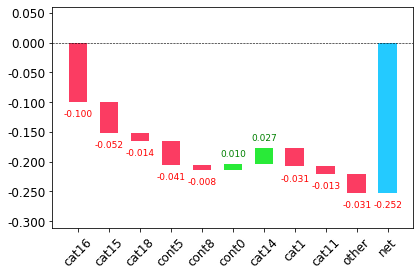

In [66]:
#This is causing an error while saving
waterfall(valid_xs_final.columns, contributions[0,:,1], threshold=0.08, 
          rotation_value=45, formatting='{:,.3f}');

**Note**: Predction for the first data point was 0 

## Training a Neural Network


...to do....